In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Only need to run once
# pip install split-folders tqdm
# import splitfolders

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import os

from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Sequential, layers, models, Model, losses
from tensorflow.keras.layers import Rescaling, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model
from keras.preprocessing.image import image_dataset_from_directory

Load and preprocess images

In [ ]:
# Split folders into train-validation-test. Only need to run once.
splitfolders.ratio("/content/drive/MyDrive/Colab Notebooks/test_images", 
                   output="/content/drive/MyDrive/Colab Notebooks/split_images", 
                   seed=1, ratio=(.6, .2, .2), group_prefix=None)

Copying files: 5539 files [02:55, 31.54 files/s]


In [3]:
batch_size = 32
img_height = 128
img_width = 128

In [4]:
# Rather than load the entire 5000+ image dataset, we'll use tf.data.Dataset to generate training and validation sets
train_dir = '/content/drive/MyDrive/Colab Notebooks/split_images/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/split_images/val'

train_ds = image_dataset_from_directory(
  train_dir,
  seed=2,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical',
  crop_to_aspect_ratio=True)

val_ds = image_dataset_from_directory(
  val_dir,
  seed=2,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical',
  crop_to_aspect_ratio=True)

Found 3318 files belonging to 12 classes.
Found 1102 files belonging to 12 classes.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


Build baseline model

In [7]:
# Preprocess images using MobileNetV2 presets
preprocess_input = mobilenet_v2.preprocess_input

In [8]:
# Augment data by flipping and rotating images
data_augmentation = Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.2),
])

# Pool features into one dimension per image
global_average_layer = layers.GlobalAveragePooling2D()

# Add a prediction layer that matches the number of categories
prediction_layer = layers.Dense(12, activation='softmax')

In [9]:
# Employ transfer learning, specifically MobileNetV2
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet',
    classes=class_names
)
# Set to false to avoid overwriting the weights in MobileNetV2
base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [10]:
# Combine the data augmentation, preprocessing, pooling, and prediction layers with MobileNetV2 base model
inputs = Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)
model = Model(inputs, outputs)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                             

In [13]:
optimizer = Adam(learning_rate=0.001)
loss = losses.CategoricalCrossentropy(from_logits=True)
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

In [14]:
mc = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/model.{epoch:02d}-{val_loss:.2f}.h5', 
                     monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=10,
          batch_size=128, 
          verbose=1,
          callbacks=mc)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


104/104 [==============================] - ETA: 0s - loss: 1.7965 - accuracy: 0.4111

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


104/104 [==============================] - 655s 6s/step - loss: 1.7965 - accuracy: 0.4111 - val_loss: 1.1711 - val_accuracy: 0.6289
Epoch 2/10
104/104 [==============================] - 31s 280ms/step - loss: 1.1081 - accuracy: 0.6215 - val_loss: 0.9300 - val_accuracy: 0.7005
Epoch 3/10
104/104 [==============================] - 30s 269ms/step - loss: 0.9006 - accuracy: 0.6953 - val_loss: 0.8236 - val_accuracy: 0.7269
Epoch 4/10
104/104 [==============================] - 30s 276ms/step - loss: 0.8322 - accuracy: 0.7149 - val_loss: 0.7723 - val_accuracy: 0.7486
Epoch 5/10
104/104 [==============================] - 30s 268ms/step - loss: 0.7507 - accuracy: 0.7321 - val_loss: 0.7191 - val_accuracy: 0.7659
Epoch 6/10
104/104 [==============================] - 30s 276ms/step - loss: 0.6984 - accuracy: 0.7577 - val_loss: 0.6867 - val_accuracy: 0.7668
Epoch 7/10
104/104 [==============================] - 30s 274ms/step - loss: 0.6692 - accuracy: 0.7694 - val_loss: 0.6713 - val_accuracy: 0.758

In [15]:
# Load the best model from Model Checkpoint callback (to reduce overfitting)
best_model = load_model('/content/drive/MyDrive/Colab Notebooks/model.09-0.64.h5')

Predict and evaluate model

In [16]:
test_dir = '/content/drive/MyDrive/Colab Notebooks/split_images/test'
test_ds = image_dataset_from_directory(
  test_dir,
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical',
  crop_to_aspect_ratio=True)

Found 1119 files belonging to 12 classes.


In [17]:
# Acheived 79% accuracy
best_model.evaluate(test_ds)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


35/35 [==============================] - 166s 4s/step - loss: 0.6103 - accuracy: 0.7882


[0.6102786660194397, 0.788203775882721]

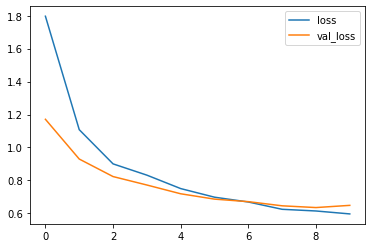

In [18]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

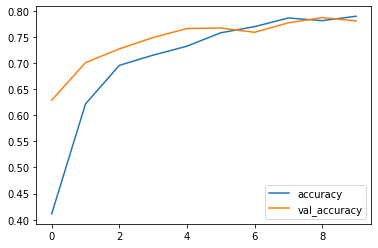

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

Save and load model

In [ ]:
# From Elizabeth's Colab Notebook
model.save('/content/drive/MyDrive/Colab Notebooks/seedling_model1.h5')


In [ ]:
model_test = load_model('/content/drive/MyDrive/Colab Notebooks/seedling_model1.h5')
model_test.summary()